#### Initial Model 

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.utils import to_categorical

def train_multiclass_bird_cnn(h5_path='bird_spectrograms_3sec_native_fixed.h5', epochs=20, batch_size=32, early_stopping_patience=3):
    # Load data from all classes
    with h5py.File(h5_path, 'r') as f:
        classes = list(f.keys())
        class_data = {}
        min_len = float('inf')
        for label in classes:
            X = np.transpose(f[label][:], (2, 0, 1)).astype('float32') / 255.0
            class_data[label] = X
            min_len = min(min_len, X.shape[0])  # Track smallest class size

    # Downsample and combine data
    X_all, y_all = [], []
    label_to_index = {label: idx for idx, label in enumerate(classes)}

    for label in classes:
        X = class_data[label]
        X = X[:min_len]  # Downsample to smallest class
        X_all.append(X)
        y_all.extend([label_to_index[label]] * min_len)

    X = np.concatenate(X_all)
    y = np.array(y_all)
    X = X[..., np.newaxis]
    X, y = shuffle(X, y, random_state=42)
    y_cat = to_categorical(y, num_classes=len(classes))

    # Split data
    X_temp, X_test, y_temp, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y_cat.argmax(1))
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp.argmax(1))

    print("Classes:", classes)
    print("Train size:", len(y_train), "Validation size:", len(y_val), "Test size:", len(y_test))

    # Define CNN
    model = models.Sequential([
        layers.Input(shape=X_train.shape[1:]),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(len(classes), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop]
    )

    # Evaluate
    loss, acc = model.evaluate(X_test, y_test)
    print(f"\nTest Accuracy: {acc:.4f}")
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))
    model.summary()

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

### Inital Paramaters 
> Batch Size = 64

> Epochs = 30

> Early Stopping = 5 


Classes: ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']
Train size: 3171 Validation size: 793 Test size: 992
Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.0938 - loss: 2.5036 - val_accuracy: 0.1173 - val_loss: 2.4737
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.0980 - loss: 2.4755 - val_accuracy: 0.2005 - val_loss: 2.3650
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.2112 - loss: 2.3264 - val_accuracy: 0.2926 - val_loss: 2.0929
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 835ms/step - accuracy: 0.3217 - loss: 2.0015 - val_accuracy: 0.3342 - val_loss: 1.9958
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 831ms/step - accuracy: 0.3731 - loss: 1.8859 - val_accuracy: 0.3808 - val_loss: 1.8933
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 833ms/step - accuracy: 0.3989 - loss: 1.7935 - val_accuracy: 0.3997 - val_loss: 1.8333
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 848ms/step

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 514, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 257, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 255, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 127, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 125, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 111104)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,946,982 (163.83 MB)

 Trainable params: 14,315,660 (54.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,631,322 (109.22 MB)

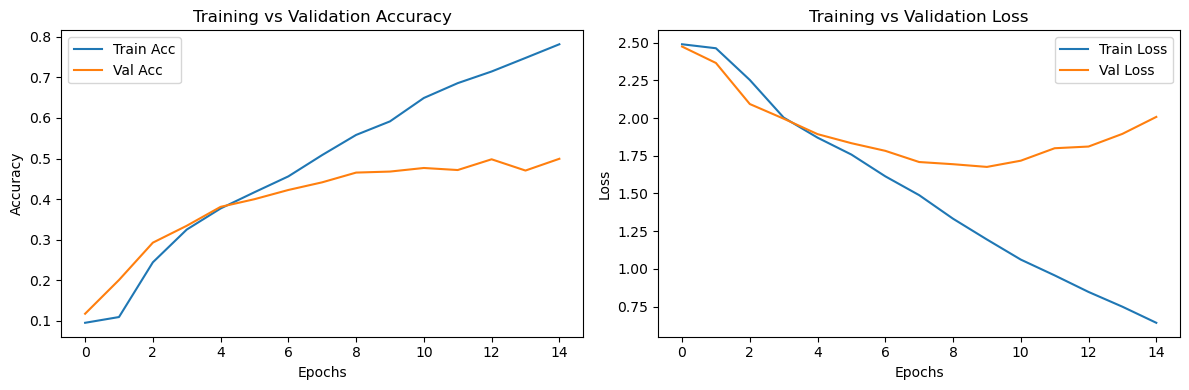

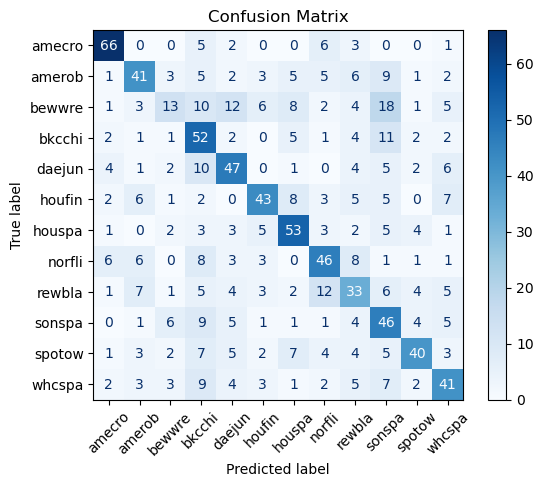

In [2]:
train_multiclass_bird_cnn(epochs=30, batch_size=64, early_stopping_patience=5)

### Dropout Increased to 0.5 from 0.4 

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.utils import to_categorical

def train_multiclass_bird_cnn1(h5_path='bird_spectrograms_3sec_native_fixed.h5', epochs=20, batch_size=32, early_stopping_patience=3):
    # Load data from all classes
    with h5py.File(h5_path, 'r') as f:
        classes = list(f.keys())
        class_data = {}
        min_len = float('inf')
        for label in classes:
            X = np.transpose(f[label][:], (2, 0, 1)).astype('float32') / 255.0
            class_data[label] = X
            min_len = min(min_len, X.shape[0])  # Track smallest class size

    # Downsample and combine data
    X_all, y_all = [], []
    label_to_index = {label: idx for idx, label in enumerate(classes)}

    for label in classes:
        X = class_data[label]
        X = X[:min_len]  # Downsample to smallest class
        X_all.append(X)
        y_all.extend([label_to_index[label]] * min_len)

    X = np.concatenate(X_all)
    y = np.array(y_all)
    X = X[..., np.newaxis]
    X, y = shuffle(X, y, random_state=42)
    y_cat = to_categorical(y, num_classes=len(classes))

    # Split data
    X_temp, X_test, y_temp, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y_cat.argmax(1))
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp.argmax(1))

    print("Classes:", classes)
    print("Train size:", len(y_train), "Validation size:", len(y_val), "Test size:", len(y_test))

    # Define CNN
    model = models.Sequential([
        layers.Input(shape=X_train.shape[1:]),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(classes), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop]
    )

    # Evaluate
    loss, acc = model.evaluate(X_test, y_test)
    print(f"\nTest Accuracy: {acc:.4f}")
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))
    model.summary()

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

### Parameters Used 
> Epochs = 30 

> Batch Size = 64 

> Early_Stopping = 10 

Classes: ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']
Train size: 3171 Validation size: 793 Test size: 992
Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 887ms/step - accuracy: 0.0940 - loss: 2.4911 - val_accuracy: 0.0845 - val_loss: 2.4848
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 879ms/step - accuracy: 0.1033 - loss: 2.4831 - val_accuracy: 0.1009 - val_loss: 2.4745
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 884ms/step - accuracy: 0.1231 - loss: 2.4516 - val_accuracy: 0.2043 - val_loss: 2.3364
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 873ms/step - accuracy: 0.2204 - loss: 2.2721 - val_accuracy: 0.3241 - val_loss: 2.0760
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 904ms/step - accuracy: 0.3096 - loss: 2.0508 - val_accuracy: 0.3909 - val_loss: 1.8938
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 876ms/step - accuracy: 0.3669 - loss: 1.8498 - val_accuracy: 0.4111 - val_loss: 1.7894
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 8

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 514, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 257, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 255, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 127, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 125, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 111104)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    14,221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,946,982 (163.83 MB)

 Trainable params: 14,315,660 (54.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,631,322 (109.22 MB)

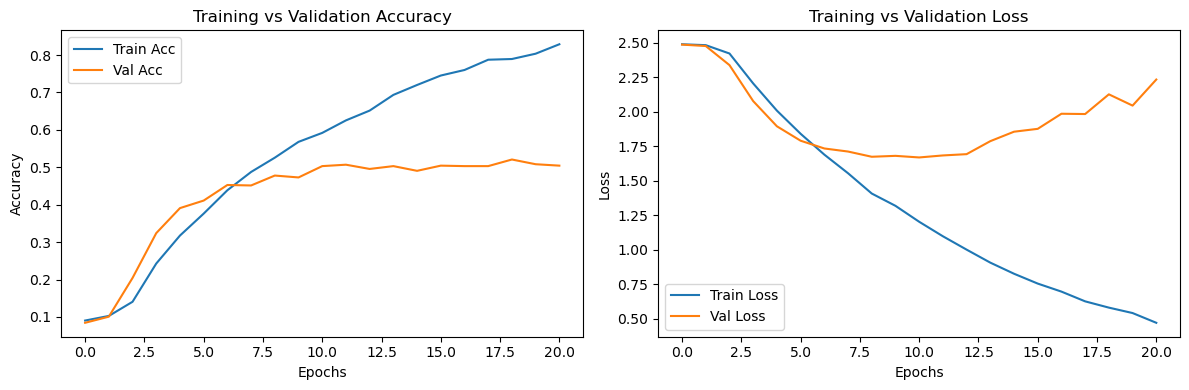

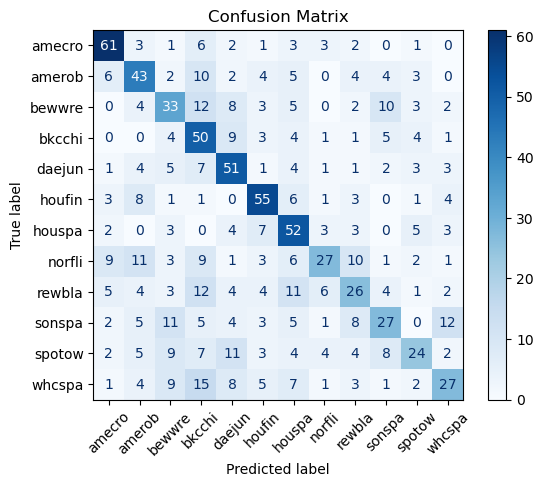

In [5]:
train_multiclass_bird_cnn1(epochs=30, batch_size=64, early_stopping_patience=10)

### CLass Weights Used 

In [4]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.utils import to_categorical

def train_multiclass_bird_cnn2(h5_path='bird_spectrograms_3sec_native_fixed.h5', epochs=20, batch_size=32, early_stopping_patience=3):
    # Load data from all classes
    with h5py.File(h5_path, 'r') as f:
        classes = list(f.keys())
        class_data = {}
        min_len = float('inf')
        for label in classes:
            X = np.transpose(f[label][:], (2, 0, 1)).astype('float32') / 255.0
            class_data[label] = X
            min_len = min(min_len, X.shape[0])  # Track smallest class size

    # Downsample and combine data
    X_all, y_all = [], []
    label_to_index = {label: idx for idx, label in enumerate(classes)}

    for label in classes:
        X = class_data[label][:min_len]  # Downsample to smallest class
        X_all.append(X)
        y_all.extend([label_to_index[label]] * min_len)

    X = np.concatenate(X_all)
    y = np.array(y_all)
    X = X[..., np.newaxis]
    X, y = shuffle(X, y, random_state=42)

    # Compute class weights using integer labels (before one-hot)
    class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
    class_weight_dict = dict(enumerate(class_weights_array))

    # One-hot encode after computing class weights
    y_cat = to_categorical(y, num_classes=len(classes))

    # Split data
    X_temp, X_test, y_temp, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y_cat.argmax(1))
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp.argmax(1))

    print("Classes:", classes)
    print("Train size:", len(y_train), "Validation size:", len(y_val), "Test size:", len(y_test))

    # Define CNN
    model = models.Sequential([
        layers.Input(shape=X_train.shape[1:]),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(classes), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        class_weight=class_weight_dict  
    )

    # Evaluate
    loss, acc = model.evaluate(X_test, y_test)
    print(f"\nTest Accuracy: {acc:.4f}")
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))
    model.summary()

    # Plot accuracy/loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

### Parameters Used 
> Epochs = 30 

> Batch Size = 64 

> Early_Stopping = 10 

Classes: ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']
Train size: 3171 Validation size: 793 Test size: 992
Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 878ms/step - accuracy: 0.0788 - loss: 2.5019 - val_accuracy: 0.0895 - val_loss: 2.4827
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 782ms/step - accuracy: 0.0924 - loss: 2.4805 - val_accuracy: 0.1211 - val_loss: 2.4739
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 676ms/step - accuracy: 0.1168 - loss: 2.4658 - val_accuracy: 0.1879 - val_loss: 2.4096
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 699ms/step - accuracy: 0.1951 - loss: 2.3626 - val_accuracy: 0.2888 - val_loss: 2.1635
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 793ms/step - accuracy: 0.2741 - loss: 2.1255 - val_accuracy: 0.3745 - val_loss: 1.9127
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 815ms/step - accuracy: 0.3166 - loss: 1.9828 - val_accuracy: 0.3770 - val_loss: 1.8406
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 8

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 514, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 257, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 255, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 127, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 125, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 111104)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    14,221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,946,982 (163.83 MB)

 Trainable params: 14,315,660 (54.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,631,322 (109.22 MB)

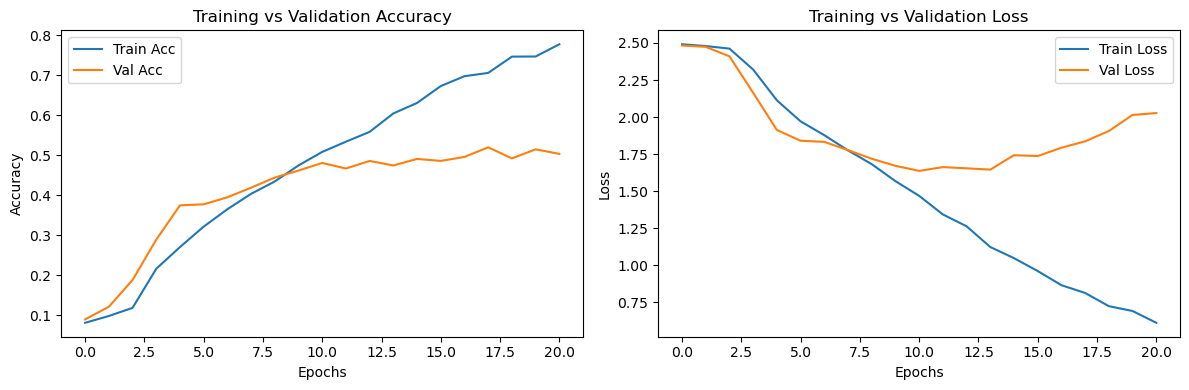

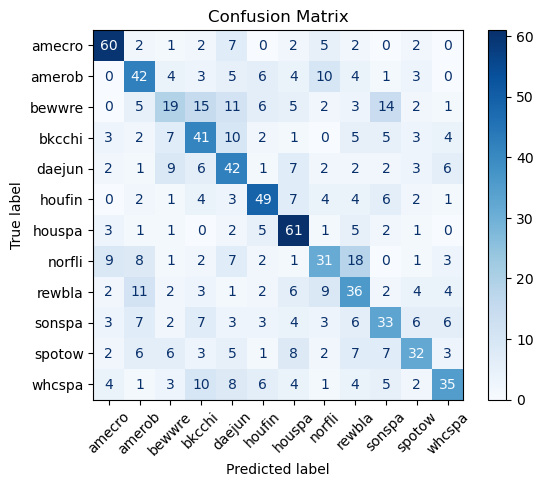

In [7]:
train_multiclass_bird_cnn1(epochs=30, batch_size=64, early_stopping_patience=10)

### Reduced dropout to 0.4 

In [28]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import random
import pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(" GPU is available:", gpus)
else:
    print(" No GPU found. Training will run on CPU.")
    

def train_multiclass_bird_cnn_dropout(h5_path='bird_spectrograms_3sec_native_fixed.h5', epochs=20, batch_size=32, early_stopping_patience=2):
    # Set seeds for reproducibility
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

    # Load data from all classes
    with h5py.File(h5_path, 'r') as f:
        classes = list(f.keys())
        class_data = {}
        min_len = float('inf')
        for label in classes:
            X = np.transpose(f[label][:], (2, 0, 1)).astype('float32') / 255.0
            class_data[label] = X
            min_len = min(min_len, X.shape[0])

    # Downsample and combine data
    X_all, y_all = [], []
    label_to_index = {label: idx for idx, label in enumerate(classes)}

    for label in classes:
        X = class_data[label][:min_len]
        X_all.append(X)
        y_all.extend([label_to_index[label]] * min_len)

    X = np.concatenate(X_all)
    y = np.array(y_all)
    X = X[..., np.newaxis]
    X, y = shuffle(X, y, random_state=42)

    # Compute class weights
    class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
    class_weight_dict = dict(enumerate(class_weights_array))
    print("Class Weights:", class_weight_dict)

    # One-hot encode labels
    y_cat = to_categorical(y, num_classes=len(classes))

    # Train/val/test split
    X_temp, X_test, y_temp, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y_cat.argmax(1))
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp.argmax(1))

    print("Classes:", classes)
    print("Train size:", len(y_train), "Validation size:", len(y_val), "Test size:", len(y_test))

    # Define CNN model
    model = models.Sequential([
    layers.Input(shape=X_train.shape[1:]),

    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),

    layers.GlobalAveragePooling2D(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(classes), activation='softmax')
])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train with early stopping
    early_stop = callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        class_weight=class_weight_dict
    )

    # Evaluate
    eval_results = model.evaluate(X_test, y_test, verbose=0)
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))
    model.summary()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Show confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

    # Save model and training history
    model.save("multiclass_bird_cnn_model.h5")
    print(" Model saved as 'multiclass_bird_cnn_model.h5'")

    with open("training_history.pkl", "wb") as f:
        pickle.dump(history.history, f)
    print(" Training history saved to 'training_history.pkl'")

    return model, classes

 GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Parameters 
> Epochs = 200
>
> Batch_Size = 64
>
> Early Stopping = 15

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
Classes: ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']
Train size: 3171 Validation size: 793 Test size: 992


2025-05-10 14:46:30.112092: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-05-10 14:46:30.112144: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-05-10 14:46:30.112157: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-05-10 14:46:30.112420: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-10 14:46:30.112450: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/200


2025-05-10 14:46:31.316089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-05-10 14:46:31.320533: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step - accuracy: 0.0865 - loss: 2.4850 - val_accuracy: 0.0845 - val_loss: 2.4849
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.0856 - loss: 2.4847 - val_accuracy: 0.0845 - val_loss: 2.4847
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 231ms/step - accuracy: 0.0768 - loss: 2.4847 - val_accuracy: 0.0845 - val_loss: 2.4842
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - accuracy: 0.0794 - loss: 2.4844 - val_accuracy: 0.0858 - val_loss: 2.4814
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - accuracy: 0.0911 - loss: 2.4847 - val_accuracy: 0.1185 - val_loss: 2.4825
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.0969 - loss: 2.4824 - val_accuracy: 0.1072 - val_loss: 2.4755
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - accuracy: 0.0963 - loss: 2.4784 - val_accuracy: 0.1097 - val_loss: 2.4736
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.0931 - loss: 2.4781 - val_accuracy

2025-05-10 15:13:54.396235: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

Confusion Matrix:
[[62  1  0  1  7  0  1  3  4  0  3  0]
 [ 1 41  1  1  8  9  3 11  4  2  2  0]
 [ 1  5 23  1  7 11  2  2  1 18  7  5]
 [ 2 10  4 56  2  0  1  1  0  3  3  1]
 [ 0  1  4  2 56  2  1  6  1  1  7  2]
 [ 2  7  3  1  4 60  3  1  0  0  2  0]
 [ 4  9  2  2  1  4 54  5  1  0  1  0]
 [10  2  3  1  7  1  0 55  2  0  2  0]
 [ 2  2  1  3  1  3  0  3 54  5  7  1]
 [ 1  5  6  4  1  3  1  1  6 49  2  3]
 [ 7  2  4  2  1  2  0  4  6  6 47  1]
 [ 1  5  7  5  4  1  0  1  2 13  2 42]]

Classification Report:
              precision    recall  f1-score   support

      amecro       0.67      0.76      0.71        82
      amerob       0.46      0.49      0.47        83
      bewwre       0.40      0.28      0.33        83
      bkcchi       0.71      0.67      0.69        83
      daejun       0.57      0.67      0.62        83
      houfin       0.62      0.72      0.67        83
      houspa       0.82      0.65      0.72        83
      norfli   

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 516, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 258, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 258, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 129, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,215,206 (4.64 MB)

 Trainable params: 405,068 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 810,138 (3.09 MB)

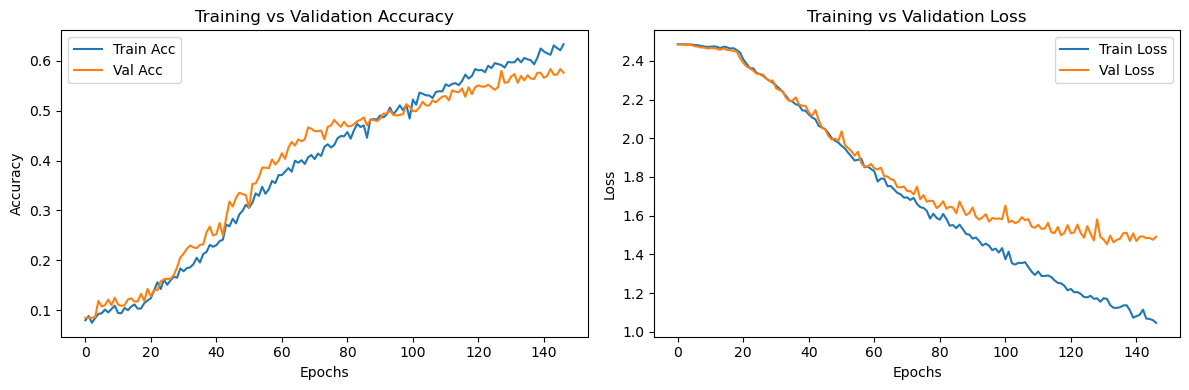

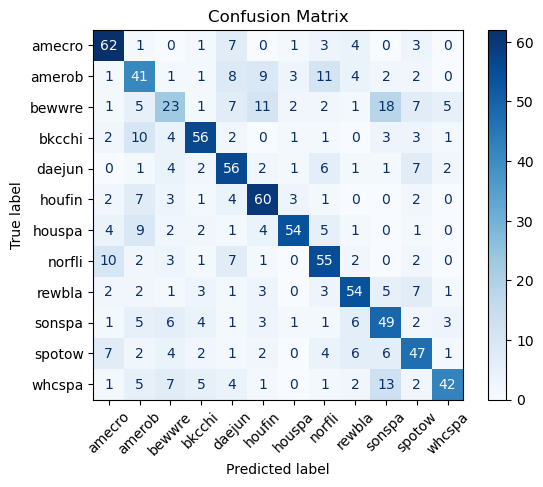

✅ Model saved as 'multiclass_bird_cnn_model.h5'
📦 Training history saved to 'training_history.pkl'


In [3]:
model, classes = train_multiclass_bird_cnn_dropout(
    h5_path='bird_spectrograms_3sec_native_fixed.h5',
    epochs=200,
    batch_size=64,
    early_stopping_patience=15 
)

### Dropout Changed to 0.3 

In [9]:
## Dropout changed to 0.3 

import numpy as np
import h5py
import matplotlib.pyplot as plt
import random
import pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  
# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available:", gpus)
else:
    print(" No GPU found. Training will run on CPU.")
    

def train_multiclass_bird_cnn_dropout(h5_path='bird_spectrograms_3sec_native_fixed.h5', epochs=20, batch_size=32, early_stopping_patience=2):
    # Set seeds for reproducibility
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

    # Load data from all classes
    with h5py.File(h5_path, 'r') as f:
        classes = list(f.keys())
        class_data = {}
        min_len = float('inf')
        for label in classes:
            X = np.transpose(f[label][:], (2, 0, 1)).astype('float32') / 255.0
            class_data[label] = X
            min_len = min(min_len, X.shape[0])

    # Downsample and combine data
    X_all, y_all = [], []
    label_to_index = {label: idx for idx, label in enumerate(classes)}

    for label in classes:
        X = class_data[label][:min_len]
        X_all.append(X)
        y_all.extend([label_to_index[label]] * min_len)

    X = np.concatenate(X_all)
    y = np.array(y_all)
    X = X[..., np.newaxis]
    X, y = shuffle(X, y, random_state=42)

    # Compute class weights
    class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
    class_weight_dict = dict(enumerate(class_weights_array))
    print("Class Weights:", class_weight_dict)

    # One-hot encode labels
    y_cat = to_categorical(y, num_classes=len(classes))

    # Train/val/test split
    X_temp, X_test, y_temp, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y_cat.argmax(1))
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp.argmax(1))

    print("Classes:", classes)
    print("Train size:", len(y_train), "Validation size:", len(y_val), "Test size:", len(y_test))

    # Define CNN model
    
    model = models.Sequential([
    layers.Input(shape=X_train.shape[1:]),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(classes), activation='softmax')
])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



    # Train with early stopping
    early_stop = callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        class_weight=class_weight_dict
    )

    # Evaluate
    eval_results = model.evaluate(X_test, y_test, verbose=0)
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))
    model.summary()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Show confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

    # Save model and training history
    model.save("multiclass_bird_cnn_model_final.keras")   
    print("Model saved as 'multiclass_bird_cnn_model_final.keras'")

    with open("training_history_Best.pkl", "wb") as f:
        pickle.dump(history.history, f)
    print(" Training history saved to 'training_history_Best.pkl'")

    return model, classes

GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Parameters 
> Epochs 200
>
> Batch Size = 64
>
> Early Stopping = 15

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
Classes: ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']
Train size: 3171 Validation size: 793 Test size: 992
Epoch 1/200


2025-05-10 15:31:37.443535: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 235ms/step - accuracy: 0.0856 - loss: 2.4851 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.0810 - loss: 2.4850 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 233ms/step - accuracy: 0.0986 - loss: 2.4850 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - accuracy: 0.0823 - loss: 2.4850 - val_accuracy: 0.0845 - val_loss: 2.4849
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 235ms/step - accuracy: 0.0732 - loss: 2.4853 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 232ms/step - accuracy: 0.0892 - loss: 2.4850 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 234ms/step - accuracy: 0.0760 - loss: 2.4851 - val_accuracy: 0.0731 - val_loss: 2.4848
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - accuracy: 0.0797 - loss: 2.4851 - val_accuracy

2025-05-10 16:05:24.124436: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

Confusion Matrix:
[[61  1  0  1  4  0  2  9  1  1  1  1]
 [ 0 43  3  5  2  5  2 15  4  2  2  0]
 [ 0  2 30  5 10  4  1  4  4 16  2  5]
 [ 1  3  4 52  3  3  1  2  5  4  2  3]
 [ 2  1  6  3 53  3  0  6  0  0  4  5]
 [ 0  3 13  3  3 42  7  4  1  3  4  0]
 [ 9  9  1  3  1  4 53  2  1  0  0  0]
 [ 4  3  3  4 11  0  1 52  3  1  1  0]
 [ 2  2  4  4  3  2  0  3 50  4  6  2]
 [ 1  3  6  8  3  1  2  1  7 42  3  5]
 [ 1  4  3  3  4  1  2  9 12  5 38  0]
 [ 1  1  9  7  6  0  0  3  4  9  2 41]]

Classification Report:
              precision    recall  f1-score   support

      amecro       0.74      0.74      0.74        82
      amerob       0.57      0.52      0.54        83
      bewwre       0.37      0.36      0.36        83
      bkcchi       0.53      0.63      0.57        83
      daejun       0.51      0.64      0.57        83
      houfin       0.65      0.51      0.57        83
      houspa       0.75      0.64      0.69        83
      norfli   

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 128, 516, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 64, 258, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 64, 258, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, 129, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,215,206 (4.64 MB)

 Trainable params: 405,068 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 810,138 (3.09 MB)

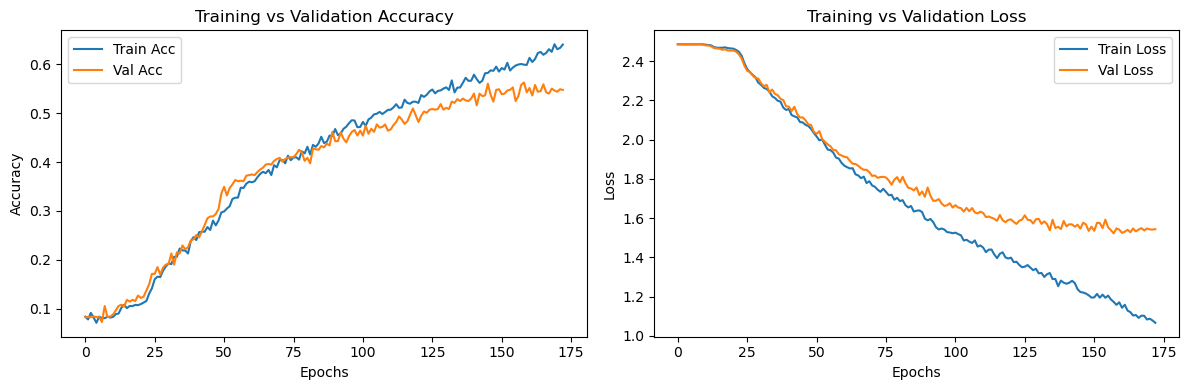

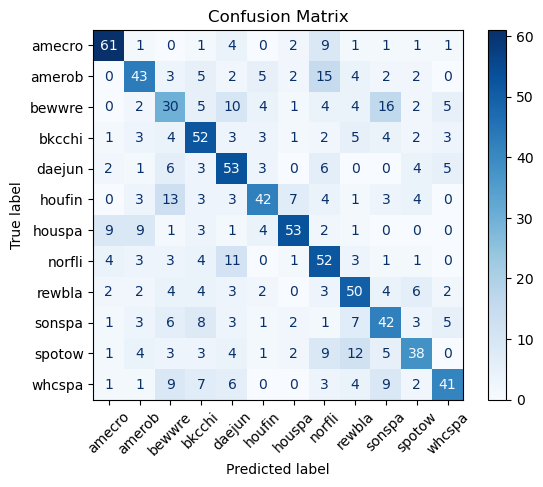

Model saved as 'multiclass_bird_cnn_model.h5'
 Training history saved to 'training_history.pkl'


In [16]:
model, classes = train_multiclass_bird_cnn_dropout(
    h5_path='bird_spectrograms_3sec_native_fixed.h5',
    epochs=200,
    batch_size=64,
    early_stopping_patience=15 
)

### Parameters 
> Epochs 125
>
> Batch Size = 64
>
> Early Stopping = 15

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
Classes: ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']
Train size: 3171 Validation size: 793 Test size: 992
Epoch 1/125


2025-05-12 00:01:05.641209: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 255ms/step - accuracy: 0.0854 - loss: 2.4851 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 2/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 230ms/step - accuracy: 0.0908 - loss: 2.4850 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 3/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - accuracy: 0.1015 - loss: 2.4849 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 4/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 233ms/step - accuracy: 0.0854 - loss: 2.4850 - val_accuracy: 0.0845 - val_loss: 2.4849
Epoch 5/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 236ms/step - accuracy: 0.0683 - loss: 2.4854 - val_accuracy: 0.0958 - val_loss: 2.4849
Epoch 6/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step - accuracy: 0.0826 - loss: 2.4850 - val_accuracy: 0.0832 - val_loss: 2.4845
Epoch 7/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - accuracy: 0.0811 - loss: 2.4856 - val_accuracy: 0.0908 - val_loss: 2.4844
Epoch 8/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 230ms/step - accuracy: 0.0790 - loss: 2.4849 - val_accuracy

2025-05-12 00:25:10.886242: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

Confusion Matrix:
[[59  1  2  0  3  1  4  6  2  3  1  0]
 [ 1 46  3  4  6  4  4  5  2  2  4  2]
 [ 0  0 33  8  8 11  2  0  0  6  5 10]
 [ 1  3  5 58  5  0  0  2  1  1  2  5]
 [ 0  0  9  2 49  2  2  3  0  2  4 10]
 [ 0  2  2  0  5 62  5  1  1  1  3  1]
 [ 7  6  1  2  1  9 54  0  2  0  1  0]
 [ 4  7  3  3  8  1  2 48  2  0  4  1]
 [ 2  1  2  5  4  6  1  1 45  5  5  5]
 [ 0  3  8  5  3  5  1  0  0 41  3 13]
 [ 5  3  4  4  2  3  0  3  2  7 48  1]
 [ 1  1  6  8  2  1  0  2  1  7  2 52]]

Classification Report:
              precision    recall  f1-score   support

      amecro       0.74      0.72      0.73        82
      amerob       0.63      0.55      0.59        83
      bewwre       0.42      0.40      0.41        83
      bkcchi       0.59      0.70      0.64        83
      daejun       0.51      0.59      0.55        83
      houfin       0.59      0.75      0.66        83
      houspa       0.72      0.65      0.68        83
      norfli   

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 516, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 258, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 258, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 129, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,215,206 (4.64 MB)

 Trainable params: 405,068 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 810,138 (3.09 MB)

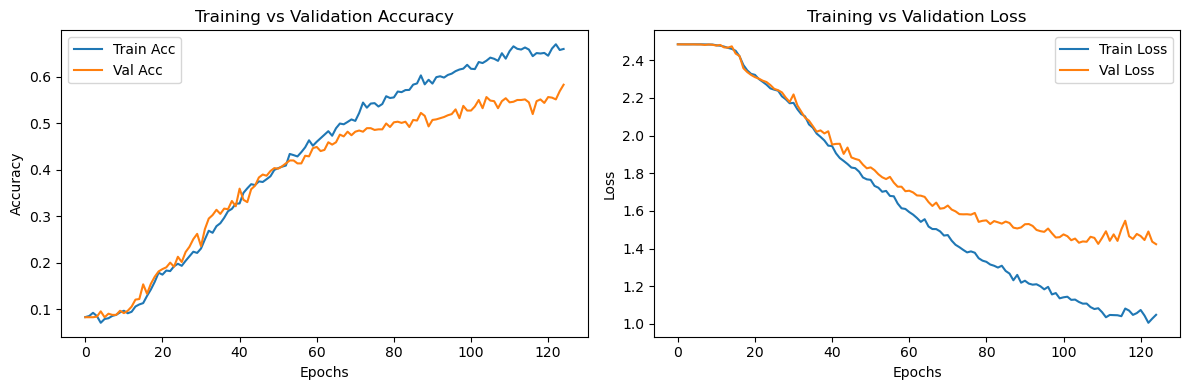

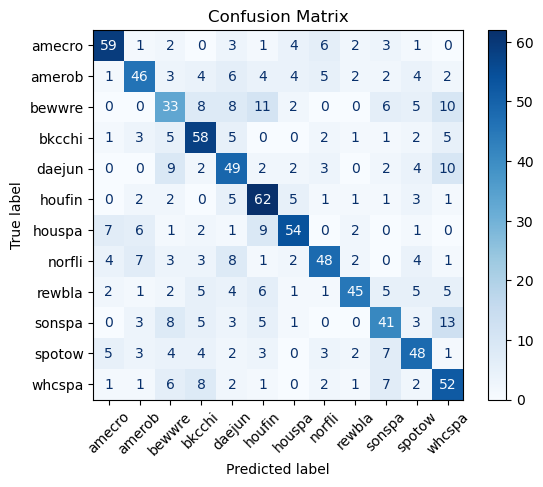

Model saved as 'multiclass_bird_cnn_model_final.keras'
 Training history saved to 'training_history_Best.pkl'


In [10]:
model, classes = train_multiclass_bird_cnn_dropout(
    h5_path='bird_spectrograms_3sec_native_fixed.h5',
    epochs=125,
    batch_size=64,
    early_stopping_patience=15
)

### Parameters 
> Epochs 75
>
> Batch Size = 64
>
> Early Stopping = 15

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
Classes: ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']
Train size: 3171 Validation size: 793 Test size: 992
Epoch 1/75


2025-05-10 17:29:30.043543: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 233ms/step - accuracy: 0.0856 - loss: 2.4851 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 2/75
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 243ms/step - accuracy: 0.0811 - loss: 2.4850 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 3/75
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.0986 - loss: 2.4849 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 4/75
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.0844 - loss: 2.4850 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 5/75
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 255ms/step - accuracy: 0.0774 - loss: 2.4853 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 6/75
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 229ms/step - accuracy: 0.0845 - loss: 2.4850 - val_accuracy: 0.0858 - val_loss: 2.4849
Epoch 7/75
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.0796 - loss: 2.4851 - val_accuracy: 0.0794 - val_loss: 2.4849
Epoch 8/75
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.0820 - loss: 2.4852 - val_accuracy: 0.098

2025-05-10 17:44:07.347182: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

Confusion Matrix:
[[53  0  3  1  6  0  6  7  4  0  2  0]
 [ 0 33  1  0 10 10  4 17  2  3  2  1]
 [ 0  2  9  5 13 18  2  2  5 21  2  4]
 [ 0  4 11 28  8  4  0  1  8  3  5 11]
 [ 1  0  4  1 47  4  1 10  6  0  6  3]
 [ 2  3  4  0  8 48  4  5  0  3  6  0]
 [ 4 10  2  0  2  4 51  4  2  0  3  1]
 [ 2  6  0  0 10  1  3 50  5  0  4  2]
 [ 3  3  1  4  4  2  1  4 45  4  8  3]
 [ 0  4  7  4  4  6  0  3  5 41  2  6]
 [ 3  5  2  1  4  4  3  9 16  5 30  0]
 [ 0  1 10  4  5  1  0  3  7  9  2 41]]

Classification Report:
              precision    recall  f1-score   support

      amecro       0.78      0.65      0.71        82
      amerob       0.46      0.40      0.43        83
      bewwre       0.17      0.11      0.13        83
      bkcchi       0.58      0.34      0.43        83
      daejun       0.39      0.57      0.46        83
      houfin       0.47      0.58      0.52        83
      houspa       0.68      0.61      0.65        83
      norfli   

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 128, 516, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 64, 258, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 64, 258, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 129, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 16, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,215,206 (4.64 MB)

 Trainable params: 405,068 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 810,138 (3.09 MB)

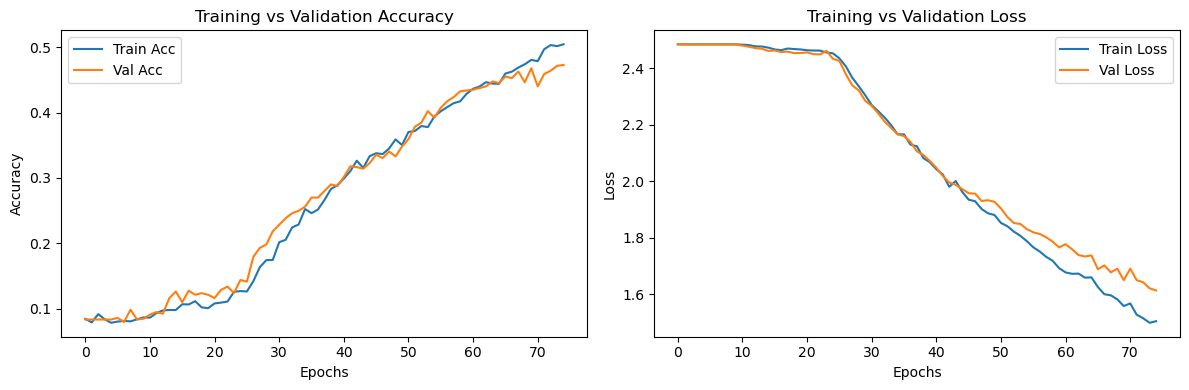

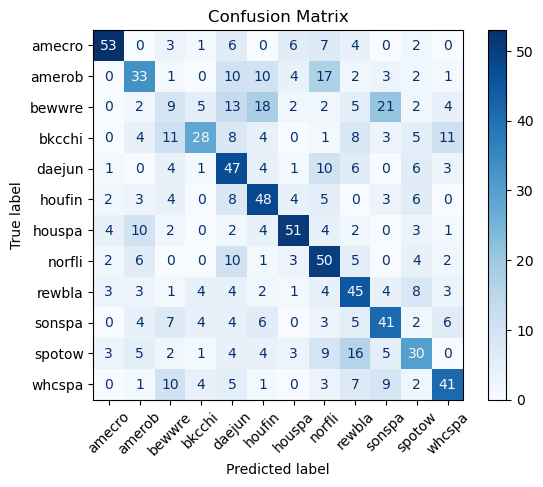

Model saved as 'multiclass_bird_cnn_model.h5'
 Training history saved to 'training_history.pkl'


In [18]:
model, classes = train_multiclass_bird_cnn_dropout(
    h5_path='bird_spectrograms_3sec_native_fixed.h5',
    epochs=75,
    batch_size=64,
    early_stopping_patience=15 
)

### Parameters 
> Epochs 75
>
> Batch Size = 128
>
> Early Stopping = 15

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
Classes: ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']
Train size: 3171 Validation size: 793 Test size: 992
Epoch 1/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 608ms/step - accuracy: 0.0818 - loss: 2.4855 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 2/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 557ms/step - accuracy: 0.0837 - loss: 2.4849 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 3/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 517ms/step - accuracy: 0.0889 - loss: 2.4849 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 4/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 505ms/step - accuracy: 0.0804 - loss: 2.4849 - val_accuracy: 0.0656 - val_loss: 2.4849
Epoch 5/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 528ms/step - accuracy: 0.0815 - loss: 2.4849 - val_accuracy: 0.0845 - val_loss: 2.4848
Epoch 6/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 514ms/step - acc

2025-05-10 18:00:15.673676: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

Confusion Matrix:
[[50  6  0  3  3  1 10  5  2  1  1  0]
 [ 1 33  4  7  4  5  5  4  7  7  6  0]
 [ 0  9  9  5 10  5  1  3  4 25  2 10]
 [ 1  7  3 40  3  2  1  1  5 10  4  6]
 [ 3  2  4  4 38  3  1  5  6  1  4 12]
 [ 2  4  8  1  7 36  5  4  3  9  3  1]
 [ 8  7  2  3  2  0 47  4  3  0  6  1]
 [17  7  1  8  8  2  9 17  6  1  7  0]
 [ 0  4  2  6  1  0  3  4 42 13  5  2]
 [ 0  2  4 11  3  1  0  0  9 48  1  3]
 [ 3  4  2  5  5  2  3  6 13  7 29  3]
 [ 0  2  2 14  5  0  0  1  2 15  3 39]]

Classification Report:
              precision    recall  f1-score   support

      amecro       0.59      0.61      0.60        82
      amerob       0.38      0.40      0.39        83
      bewwre       0.22      0.11      0.15        83
      bkcchi       0.37      0.48      0.42        83
      daejun       0.43      0.46      0.44        83
      houfin       0.63      0.43      0.51        83
      houspa       0.55      0.57      0.56        83
      norfli   

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 128, 516, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 64, 258, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 64, 258, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 32, 129, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 16, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,215,206 (4.64 MB)

 Trainable params: 405,068 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 810,138 (3.09 MB)

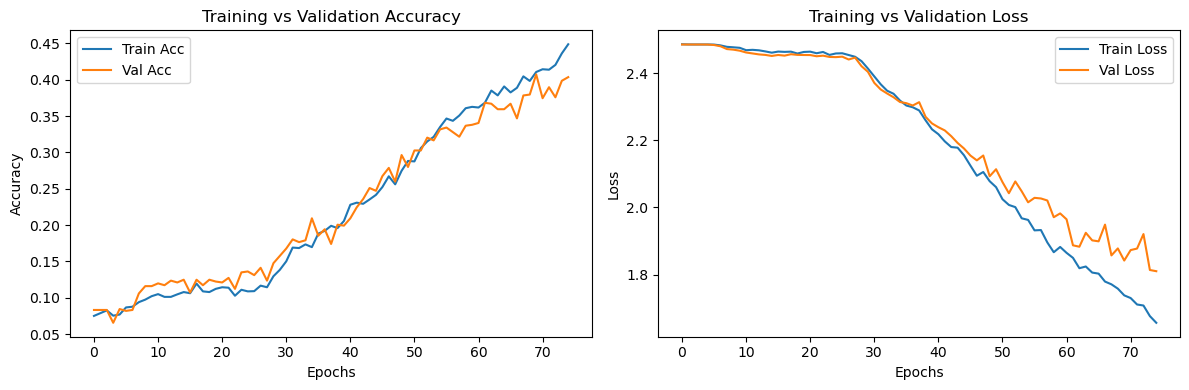

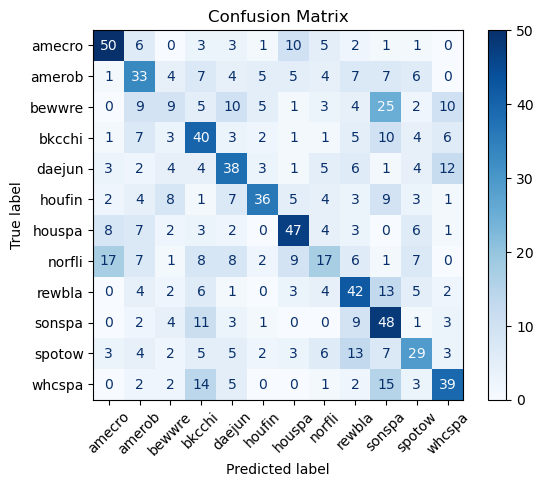

Model saved as 'multiclass_bird_cnn_model.h5'
 Training history saved to 'training_history.pkl'


In [19]:
model, classes = train_multiclass_bird_cnn_dropout(
    h5_path='bird_spectrograms_3sec_native_fixed.h5',
    epochs=75,
    batch_size=128,
    early_stopping_patience=15 
)

### Parameters 
> Epochs 75
>
> Batch Size = 256
>
> Early Stopping = 15

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
Classes: ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']
Train size: 3171 Validation size: 793 Test size: 992
Epoch 1/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.0767 - loss: 2.4854 - val_accuracy: 0.0832 - val_loss: 2.4847
Epoch 2/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.0918 - loss: 2.4847 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 3/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.0867 - loss: 2.4846 - val_accuracy: 0.0832 - val_loss: 2.4844
Epoch 4/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.0917 - loss: 2.4843 - val_accuracy: 0.0908 - val_loss: 2.4834
Epoch 5/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.0865 - loss: 2.4829 - val_accuracy: 0.0845 - val_loss: 2.4805
Epoch 6/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.0890 - lo

2025-05-10 18:18:21.021480: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

Confusion Matrix:
[[53  0  0  4  9  0 10  2  2  0  2  0]
 [ 3 15  4  4 17  5 11  5  6  2 10  1]
 [ 1  7 11  1 21 12  6  1  2 12  4  5]
 [ 2  9  3 18 25  7  5  2  1  3  0  8]
 [ 4  0  6  1 50  6  9  0  2  1  3  1]
 [ 0  1  2  1 26 25  9  3  3  1 12  0]
 [ 7  1  1  1 13  2 44  2  2  0 10  0]
 [15  4  0  1 18  2 16 12  1  1 13  0]
 [ 4  0  3  3  7  2  3  2 40  6 11  1]
 [ 0  4  8  4  8 14  6  0  4 24  4  6]
 [ 8  3  1  3 14  4  9  0  6  3 31  0]
 [ 1  1  5 10  9  2  0  0  3 11  3 38]]

Classification Report:
              precision    recall  f1-score   support

      amecro       0.54      0.65      0.59        82
      amerob       0.33      0.18      0.23        83
      bewwre       0.25      0.13      0.17        83
      bkcchi       0.35      0.22      0.27        83
      daejun       0.23      0.60      0.33        83
      houfin       0.31      0.30      0.30        83
      houspa       0.34      0.53      0.42        83
      norfli   

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 128, 516, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 64, 258, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 64, 258, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 32, 129, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 16, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,215,206 (4.64 MB)

 Trainable params: 405,068 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 810,138 (3.09 MB)

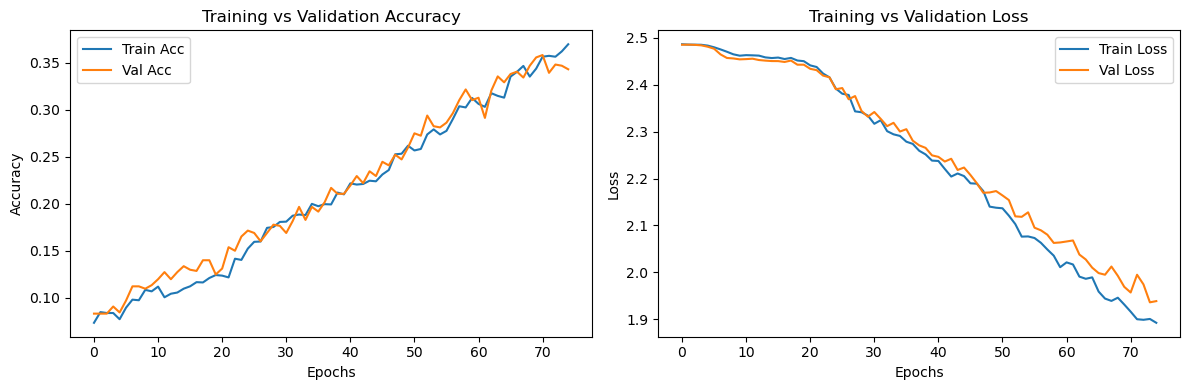

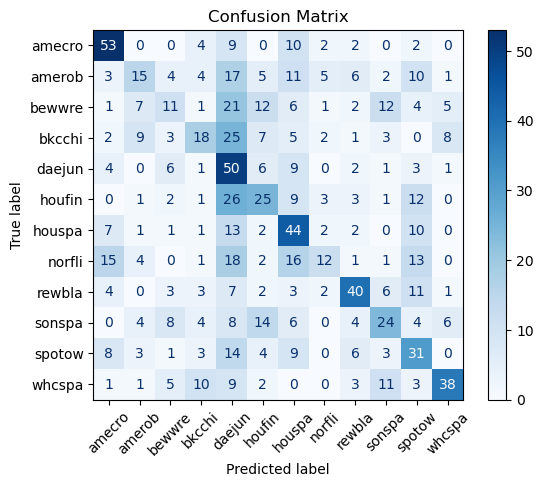

Model saved as 'multiclass_bird_cnn_model.h5'
 Training history saved to 'training_history.pkl'


In [20]:
model, classes = train_multiclass_bird_cnn_dropout(
    h5_path='bird_spectrograms_3sec_native_fixed.h5',
    epochs=75,
    batch_size=256,
    early_stopping_patience=15 
)

### Parameters 
> Epochs 75
>
> Batch Size = 512
>
> Early Stopping = 15

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
Classes: ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']
Train size: 3171 Validation size: 793 Test size: 992
Epoch 1/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.0793 - loss: 2.4851 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 2/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.0872 - loss: 2.4847 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 3/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.0857 - loss: 2.4848 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 4/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.0888 - loss: 2.4848 - val_accuracy: 0.0832 - val_loss: 2.4850
Epoch 5/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.0869 - loss: 2.4848 - val_accuracy: 0.0832 - val_loss: 2.4849
Epoch 6/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.0951 - loss: 2.4842 -

2025-05-10 18:43:11.984768: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

Confusion Matrix:
[[ 0 13  0  0 15  4  5 23 11  7  0  4]
 [ 0 15  0  0 15  4  4  8  8 22  0  7]
 [ 0 21  0  0 18  2  2  6  2 28  0  4]
 [ 0 23  0  0 28  3  5 10  4  7  0  3]
 [ 0 18  0  0 27  2  4  7  5 19  0  1]
 [ 0  7  0  0 11  5 11  9 13 23  0  4]
 [ 0 12  0  0 18  4 11 16  6 14  0  2]
 [ 0 11  0  0 27  3  4 12  8 15  0  3]
 [ 0 13  0  0  9  6  1  9 20 22  0  2]
 [ 0 11  0  0 13  4  3  5 13 31  0  2]
 [ 0 15  0  0  6  5  3 13 13 21  0  6]
 [ 0 14  0  0  8  2  2 12 11 28  0  6]]

Classification Report:
              precision    recall  f1-score   support

      amecro       0.00      0.00      0.00        82
      amerob       0.09      0.18      0.12        83
      bewwre       0.00      0.00      0.00        83
      bkcchi       0.00      0.00      0.00        83
      daejun       0.14      0.33      0.19        83
      houfin       0.11      0.06      0.08        83
      houspa       0.20      0.13      0.16        83
      norfli   

/Users/sanro/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sanro/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sanro/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 128, 516, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 64, 258, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 64, 258, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 32, 129, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 16, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,215,206 (4.64 MB)

 Trainable params: 405,068 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 810,138 (3.09 MB)

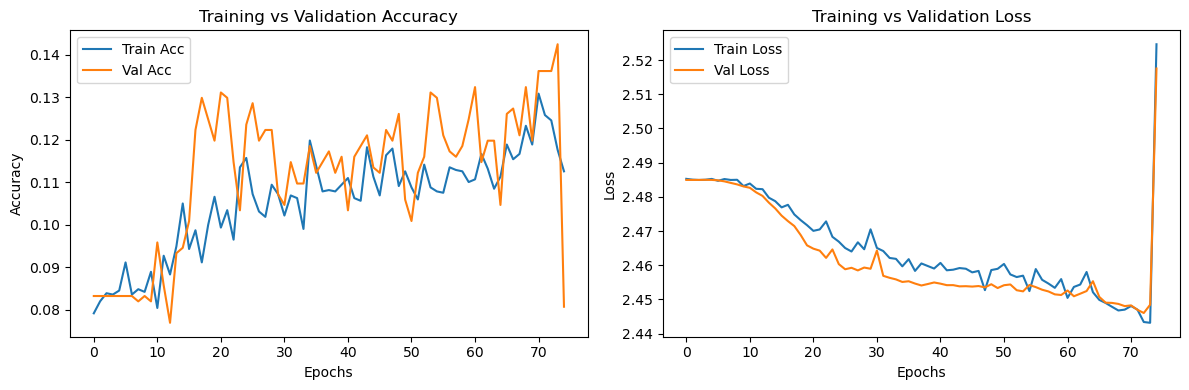

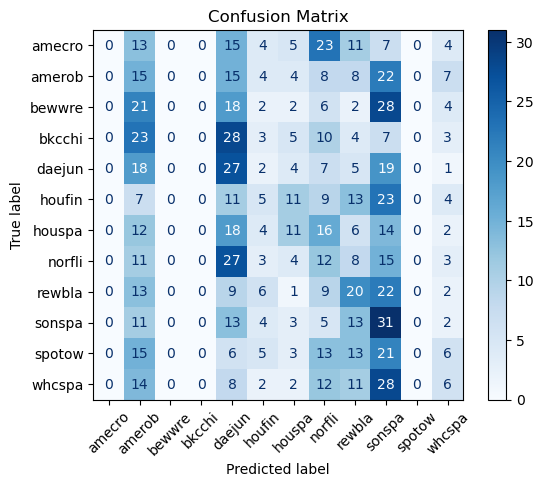

Model saved as 'multiclass_bird_cnn_model.h5'
 Training history saved to 'training_history.pkl'


In [21]:
model, classes = train_multiclass_bird_cnn_dropout(
    h5_path='bird_spectrograms_3sec_native_fixed.h5',
    epochs=75,
    batch_size=512,
    early_stopping_patience=15 
)